# Импорт библиотек

In [1]:
# based on https://www.kaggle.com/konstanter/fasterrcnn-pytorch-maskdetection

import numpy as np
import pandas as pd
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import os
import glob
import xml.etree.ElementTree as et
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content

Mounted at /content/gdrive
/content


In [3]:
# Загрузка датасета
if not os.path.exists("masks"):
    !unzip -q gdrive/MyDrive/masks.zip -d ../content/

# Загрузка данных в DataLoader

In [4]:
# путь к файлам
images_dir = './images/'
annotations_dir = './annotations/'


class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width

        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]

        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения
        img = cv2.imread(image_path) #HWC
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0

        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]

        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            # correct anomalies when xmax > width or ymax > height
            if xmax_corr > self.width:
                xmax_corr = self.width
            if ymax_corr > self.height:
                ymax_corr = self.height
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[35]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[ 15.6800,  53.5221,  24.6400,  70.3717],
        [ 54.8800,  61.4513,  63.8400,  79.2920],
        [ 90.7200,  50.5487, 108.6400,  88.2124],
        [164.0800,  59.4690, 175.2800,  80.2832],
        [197.1200,  52.5310, 208.8800,  70.3717],
        [128.2400,  52.5310, 134.9600,  71.3628]]), 'labels': tensor([2, 2, 3, 2, 2, 2]), 'area': tensor([150.9720, 159.8527, 674.9337, 233.1186, 209.8069, 126.5501]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'image_id': tensor([35])}


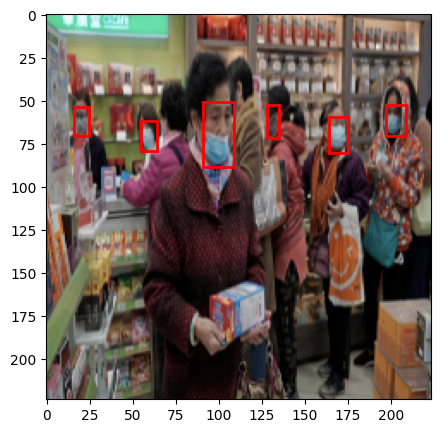

In [5]:
# Вспомогательная функция для визуализации bbox

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Отрисуем bbox поверх картинки
        a.add_patch(rect)
    plt.show()

img, target = dataset[35]
plot_img_bbox(img, target)

In [6]:
def get_transform(train):

    if train:
        return A.Compose([
                            #A.HorizontalFlip(0.5),
                            #A.RandomBrightnessContrast(p=0.2),
                            #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=False))

# разделим данные на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


# Обучение модели
We're going to use fasterrcnn_resnet50_fpn.

The model has 4 children: transform, backbone, rpn, roi_heads. Transform deals with input normalization. Backbone is a Resnet-50 architecture along with feature pyramid network. Region Proposal network (rpn) generates candidate proposals for Region of Interest network (roi_heads).

In [9]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [10]:
for imgs, annotations in next(iter(data_loader)):
  print(imgs[0].shape)
  print(annotations[0])
  break


ValueError: too many values to unpack (expected 2)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4

model = get_model_instance_segmentation(num_classes)

num_epochs = 3

model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    model.eval()
    with torch.no_grad():
      for images, annotations in data_loader_test:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        #trues = [t['labels'] for t in targets]
        #predict = model(images, annotations)['labels']

        #for t,p in zip(trues, preds):
        #      val_accur.append(get_accuracy(t, p))


    print('Epoch_loss = ',epoch_loss)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 108MB/s]


Epoch_loss =  71.88753297179937
Epoch_loss =  47.15568494051695
Epoch_loss =  39.8683886192739


In [14]:
torch.save(model.state_dict(), 'gdrive/MyDrive/res.pt')

#!zip -r model.zip model/res.pt

#files.download("model.zip")

In [18]:
model.eval()
with torch.no_grad():
  for images, annotations in data_loader_test:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    trues = [t['labels'] for t in targets]
    predict = model(images, annotations)
    preds = [p['labels'] for p in predict]
    break
print('Targets',targets)
print('Predicts', predict)

Targets [{'boxes': tensor([[210.0000,  98.8764, 258.0000, 167.1910],
        [  9.6000, 303.8202,  87.6000, 451.2360],
        [152.4000, 332.5843, 213.6000, 422.4719],
        [318.0000, 332.5843, 348.0000, 406.2921],
        [384.0000, 357.7528, 439.2000, 467.4157],
        [318.0000, 285.8427, 336.0000, 318.2022],
        [390.0000, 257.0786, 410.4000, 278.6517],
        [394.8000, 303.8202, 420.0000, 346.9663],
        [379.2000, 262.4719, 390.0000, 284.0450]], device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 3, 2], device='cuda:0'), 'area': tensor([ 3279.1011, 11498.4277,  5501.1260,  2211.2366,  6053.3950,   582.4720,
          440.0897,  1087.2811,   232.9884], device='cuda:0'), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), 'image_id': tensor([204], device='cuda:0')}, {'boxes': tensor([[ 99.6000,  77.0149, 132.0000, 134.3284],
        [166.8000, 116.4179, 200.4000, 168.3582],
        [222.0000, 125.3731, 244.8000, 159.4030],
        [273.6000, 120.0000

In [ ]:
--

### NMS
Performs non-maximum suppression (NMS) on the boxes according to their intersection-over-union (IoU).

NMS iteratively removes lower scoring boxes which have an IoU greater than iou_threshold with another (higher scoring) box.

If multiple boxes have the exact same score and satisfy the IoU criterion with respect to a reference box, the selected box is not guaranteed to be the same between CPU and GPU. This is similar to the behavior of argsort in PyTorch when repeated values are present.

In [ ]:
# вспомогательная функция принимает исходный прогноз и порог iou

def apply_nms(orig_prediction, iou_thresh=0.3):

    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [ ]:
img, target = dataset_test[4]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))
#prediction

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

# Отрисовка изображений

In [ ]:
def plot_image(img_tensor, annotation,predict=True):

    fig,ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)
    img = img_tensor.cpu().data
    mask_dic = {1:'without_mask', 2:'with_mask', 3:'mask_weared_incorrect'}

    ax.imshow(img.permute(1, 2, 0))

    for i,box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)
        label = mask_dic[int(annotation['labels'][i].data)]
        if predict:
            score = int((annotation['scores'][i].data) * 100)
            ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
        else:
            score=''
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
    plt.show()

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)

preds

In [ ]:
nms_prediction = apply_nms(preds[4], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[4], nms_prediction)
print("Target")
plot_image(imgs[4].to('cpu'), annotations[4],False)

In [ ]:
nms_prediction = apply_nms(preds[7], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[7], nms_prediction)
print("Target")
plot_image(imgs[7].to('cpu'), annotations[7],False)

In [ ]:
nms_prediction = apply_nms(preds[0], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[0], nms_prediction)
print("Target")
plot_image(imgs[0].to('cpu'), annotations[0],False)

In [ ]:
nms_prediction = apply_nms(preds[2], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[2], nms_prediction)
print("Target")
plot_image(imgs[2].to('cpu'), annotations[2],False)